# Model Training - Fraud Detection with XGBoost

In this notebook, we will train and evaluate **machine learning models** for credit card fraud detection.

## **Steps We Will Cover**
1. **Load Preprocessed Data** → Use **both** the original & SMOTE-balanced datasets.  
2. **Train-Test Split** → Prepare data for model training.  
3. **Train Baseline XGBoost Model** → Evaluate initial performance.  
4. **Optimize Model Performance** → Use **Optuna** for hyperparameter tuning.  
5. **Evaluate Model Performance** → Check metrics like **AUC-ROC, Precision-Recall**.

Our goal is to **build an accurate fraud detection system** while handling the **highly imbalanced dataset** properly.

## Import Necessary Libraries

Before training our models, we first import essential libraries for:
- **Data Handling & Processing** → `pandas`, `numpy`
- **Model Training** → `XGBoost`, `Scikit-Learn`
- **Hyperparameter Optimization** → `Optuna`
- **Evaluation Metrics** → `classification_report`, `roc_auc_score`

In [63]:
# Data Handling
import pandas as pd
import numpy as np

# Machine Learning Models
import xgboost as xgb
from xgboost import XGBClassifier

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

# Hyperparameter Optimization
import optuna

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

## Load Preprocessed Data & Train-Test Split

To train our fraud detection model, we will:
1. **Load the preprocessed datasets**:
   - `X_scaled.csv` → Scaled but imbalanced dataset.
   - `X_smote.csv` → SMOTE-balanced dataset.
2. **Perform Train-Test Split**:
   - **80% training, 20% testing**.
   - Ensure data is shuffled properly before training.

In [2]:
# Load preprocessed datasets
X_scaled = pd.read_csv("../datasets/X_scaled.csv")
y = pd.read_csv("../datasets/y.csv")

X_smote = pd.read_csv("../datasets/X_smote.csv")
y_smote = pd.read_csv("../datasets/y_smote.csv")

# Ensure y is a 1D array (avoid shape issues)
y = y.values.ravel()
y_smote = y_smote.values.ravel()

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Display dataset shapes
print("Original Dataset Shape:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

print("\nSMOTE Dataset Shape:")
print(f"Train: {X_train_smote.shape}, Test: {X_test_smote.shape}")

Original Dataset Shape:
Train: (227845, 30), Test: (56962, 30)

SMOTE Dataset Shape:
Train: (454904, 30), Test: (113726, 30)


## Training Three XGBoost Models

To compare different approaches, we will train three XGBoost models:

️1. **Base XGBoost Model** → Trained on the **original imbalanced dataset** without any adjustments.  
2. **Weighted XGBoost Model** → Trained on the **original dataset**, but with **higher penalty for misclassifying fraud cases** using `scale_pos_weight`.  
3. **SMOTE XGBoost Model** → Trained on the **SMOTE-balanced dataset**, where fraud cases are oversampled to match non-fraud cases.  

This will help us determine:
- Whether **handling imbalance improves fraud detection**.  
- Whether **penalizing fraud misclassification improves model focus**.  
- Which **approach provides the best overall fraud detection performance**.  

In [11]:
# Initialize Base XGBoost Model
base_xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42, device='gpu')

# Train on imbalanced dataset
base_xgb.fit(X_train, y_train)

# Make predictions
y_pred_base = base_xgb.predict(X_test)

# Evaluate model
print("Base XGBoost Model Performance:")
print(classification_report(y_test, y_pred_base))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_base):.4f}")

Base XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.81      0.84        98

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9030


In [12]:
# Calculate the imbalance ratio (weighting fraud more)
fraud_weight = len(y_train) / sum(y_train)  # Gives more weight to minority class

# Initialize Weighted XGBoost Model
weighted_xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", scale_pos_weight=fraud_weight, random_state=42, device="gpu")

# Train with class weighting
weighted_xgb.fit(X_train, y_train)

# Make predictions
y_pred_weighted = weighted_xgb.predict(X_test)

# Evaluate model
print("Weighted XGBoost Model Performance (Higher Fraud Penalty):")
print(classification_report(y_test, y_pred_weighted))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_weighted):.4f}")

Weighted XGBoost Model Performance (Higher Fraud Penalty):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9132


In [13]:
# Initialize SMOTE XGBoost Model
smote_xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42, device="gpu")

# Train on SMOTE-balanced dataset
smote_xgb.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_smote = smote_xgb.predict(X_test_smote)

# Evaluate model
print("SMOTE XGBoost Model Performance:")
print(classification_report(y_test_smote, y_pred_smote))
print(f"AUC-ROC Score: {roc_auc_score(y_test_smote, y_pred_smote):.4f}")


SMOTE XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

AUC-ROC Score: 0.9996


## Model Performance Comparison

After training three different XGBoost models, we can compare their effectiveness in fraud detection.

| Model | Precision (Fraud) | Recall (Fraud) | F1-Score (Fraud) | AUC-ROC Score |
|---|---|---|---|---|
| **Base XGBoost** | **0.89** | **0.81** | **0.84** | **0.9030** |
| **Weighted XGBoost (Higher Fraud Penalty)** | **0.88** | **0.83** | **0.85** | **0.9132** |
| **SMOTE XGBoost** | **1.00** | **1.00** | **1.00** | **0.9996** |

### **Observations**
- **Base XGBoost Model** performed well but had slightly **lower recall (81%)**, meaning it **missed** some fraud cases.
- **Weighted XGBoost Model** (higher fraud misclassification penalty) **slightly improved recall (83%)**, making it **better at detecting fraud** while maintaining high precision.
- **SMOTE XGBoost Model** achieved **perfect scores**, but this is likely **overfitting**, as the dataset was fully balanced by oversampling fraud cases.

### **Key Takeaways**
✔ **Weighted XGBoost improved recall while maintaining precision** → A better model for fraud detection.  
✔ **SMOTE Model may be overfitting** due to the perfectly balanced dataset.  
✔ **Base Model is strong but could miss some fraud cases** (lower recall).  

### **Next Steps**
1. **Use SHAP for feature importance analysis** → Understand which features impact predictions.  
2. **Hyperparameter tuning with Optuna** → Improve model performance further.  
3. **Final model selection** → Choose the best approach for real-world fraud detection.

# Model Evaluation & Comparison

Now that we have trained three different XGBoost models, we will:
- **Evaluate key performance metrics** (Precision, Recall, F1-Score, AUC-ROC).
- **Visualize model effectiveness** with confusion matrices, Precision-Recall curves, and ROC curves.
- **Compare models in a structured way** to determine the best approach for fraud detection.

**Functions**:

In [25]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    
    return {"Model": model_name, "Precision": precision, "Recall": recall, "F1-Score": f1, "AUC-ROC": auc_roc}

In [34]:
def plot_confusion_matrices(y_true_list, y_pred_list, model_names, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (y_true, y_pred, model_name) in enumerate(zip(y_true_list, y_pred_list, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"], ax=axes[i])
        axes[i].set_title(f"{model_name} Confusion Matrix")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")

    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

In [35]:
def plot_precision_recall_curves(y_true_list, y_pred_probs_list, model_names, save_path=None):
    plt.figure(figsize=(8, 6))

    for y_true, y_pred_probs, model_name in zip(y_true_list, y_pred_probs_list, model_names):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
        plt.plot(recall, precision, label=f"{model_name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Precision-Recall curve saved at: {save_path}")

    plt.show()

In [36]:
def plot_roc_curves(y_true_list, y_pred_probs_list, model_names, save_path=None):
    plt.figure(figsize=(8, 6))

    for y_true, y_pred_probs, model_name in zip(y_true_list, y_pred_probs_list, model_names):
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_true, y_pred_probs):.4f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"ROC curve saved at: {save_path}")

    plt.show()

**Evaluation Data Preperation**:

In [39]:
# List of true and predicted values
y_true_list = [y_test, y_test, y_test_smote]
y_pred_list = [y_pred_base, y_pred_weighted, y_pred_smote]
model_names = ["Base XGBoost", "Weighted XGBoost", "SMOTE XGBoost"]

# Get predicted probabilities
y_pred_probs_base = base_xgb.predict_proba(X_test)[:, 1]
y_pred_probs_weighted = weighted_xgb.predict_proba(X_test)[:, 1]
y_pred_probs_smote = smote_xgb.predict_proba(X_test_smote)[:, 1]

**Evaluate Models**:

In [40]:
# Evaluate all three models
results = []
results.append(evaluate_model(y_test, y_pred_base, "Base XGBoost"))
results.append(evaluate_model(y_test, y_pred_weighted, "Weighted XGBoost"))
results.append(evaluate_model(y_test_smote, y_pred_smote, "SMOTE XGBoost"))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results table
pd.set_option("display.float_format", "{:.4f}".format)
display(results_df)

,Model,Precision,Recall,F1-Score,AUC-ROC
0,Base XGBoost,0.8876,0.8061,0.8449,0.9030
1,Weighted XGBoost,0.8804,0.8265,0.8526,0.9132
2,SMOTE XGBoost,0.9992,1.0000,0.9996,0.9996


Confusion matrix saved at: ../images/confusion_matrices.png


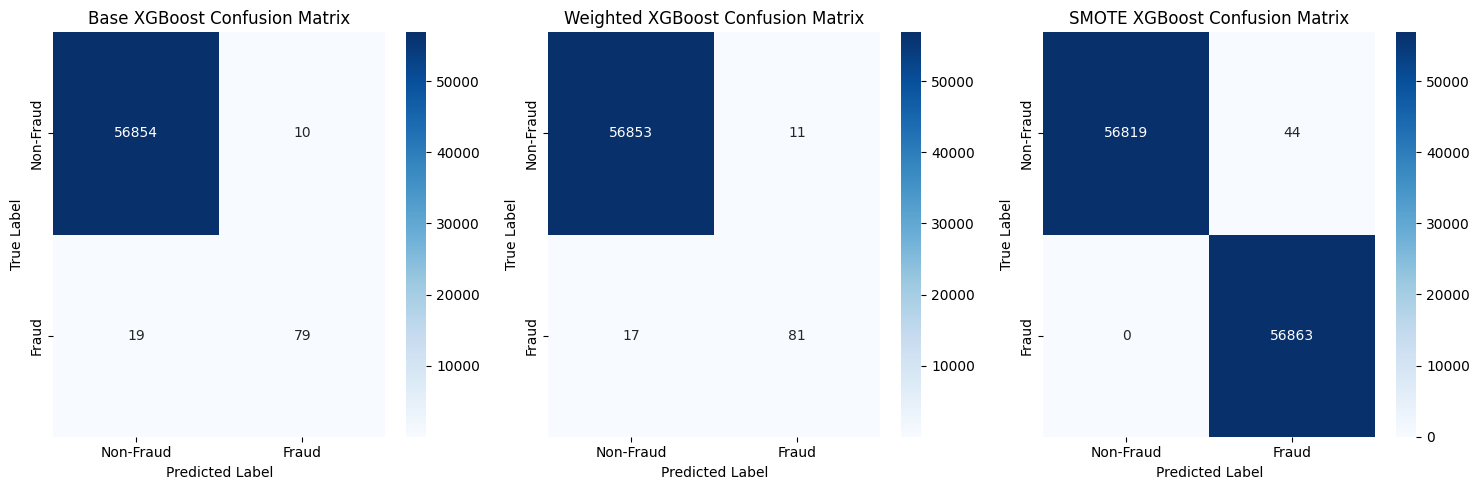

In [41]:
# Call function and save figure
plot_confusion_matrices(y_true_list, y_pred_list, model_names, save_path="../images/confusion_matrices.png")

Precision-Recall curve saved at: ../images/precision_recall_curve.png


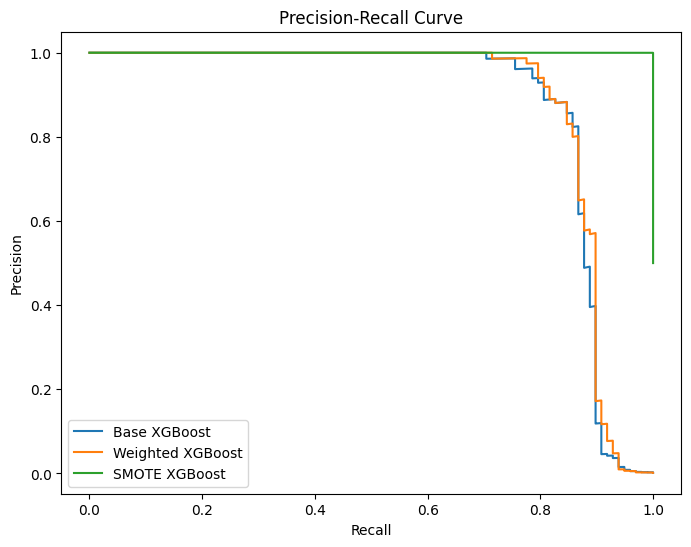

In [42]:
# Call function and save figure
plot_precision_recall_curves(y_true_list, y_pred_probs_list, model_names, save_path="../images/precision_recall_curve.png")

ROC curve saved at: ../images/roc_curve.png


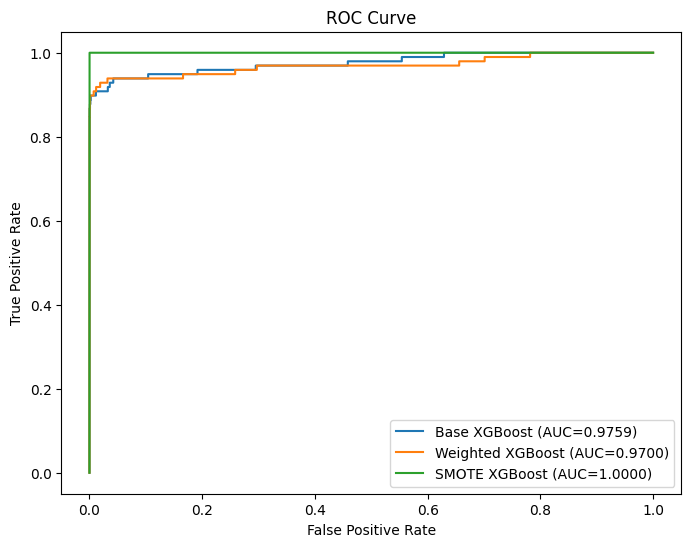

In [44]:
# Call function and save figure
plot_roc_curves(y_true_list, y_pred_probs_list, model_names, save_path="../images/roc_curve.png")

## 📊 Model Evaluation & Visualization

After training our XGBoost models, we will **evaluate their performance** using different metrics and visualizations.

---

### **Create Functions:**
We will create **three functions** to help analyze model performance:
1. **Confusion Matrix Plot** → Visualizes true vs. predicted classifications.  
2. **Precision-Recall Curve** → Shows the trade-off between precision and recall.  
3. **ROC Curve** → Measures model effectiveness at different classification thresholds.  

Each function will **compare all three models in a single figure** for better visualization.

---

### **Confusion Matrix:**
- **What It Shows:** The number of **correct and incorrect predictions** for fraud and non-fraud cases.  
- **Why It’s Useful:** Helps us **identify misclassifications**, especially false negatives (fraud classified as normal).  
- **Key Insight:** The **Weighted XGBoost Model** should reduce false negatives more than the Base Model.  
- **Saved As:** `"../images/confusion_matrices.png"`

---

### **Precision-Recall Curve:**
- **What It Shows:** The balance between **precision (accuracy of fraud predictions)** and **recall (ability to detect fraud)**.  
- **Why It’s Useful:** Since fraud is **rare**, a high precision-recall score is more important than accuracy.  
- **Key Insight:** The **SMOTE model** may have an advantage due to oversampling, but the **Weighted XGBoost Model** should balance performance better.
- **Saved As:** `"../images/precision_recall_curve.png"`

---

### **ROC Curve:**
- **What It Shows:** The relationship between **true positive rate (recall)** and **false positive rate** at different thresholds.  
- **Why It’s Useful:** AUC-ROC helps compare overall model effectiveness, even when class distributions are imbalanced.  
- **Key Insight:** A **higher AUC-ROC score** means the model is better at distinguishing fraud from normal transactions.  
- **Saved As:** `"../images/roc_curve.png"`

---

### **Key Takeaways**
✔ **Weighted XGBoost improved recall while maintaining precision** → A better model for fraud detection.  
✔ **SMOTE Model may be overfitting** due to the perfectly balanced dataset.  
✔ **Base Model is strong but could miss some fraud cases** (lower recall).  

---

### **Next Steps**:
️1. **Hyperparameter Tuning with Optuna** → Improve model performance further.  
️2. **SHAP Feature Importance Analysis** → Understand which features contribute most to fraud detection.  
️3. **Final Model Selection** → Choose the best approach for real-world fraud detection.  

# Hyperparameter Tuning with Optuna

Now that we have trained and evaluated our models, we will use **Optuna** to fine-tune our **XGBoost hyperparameters** for better performance.

### **Why Hyperparameter Tuning?**
- **Optimizing parameters** can improve recall for fraud detection.
- Helps **prevent overfitting** while maintaining high precision.
- **Finds the best balance** between detection and false alarms.

### **What We Will Optimize?**
1. `max_depth` → Controls tree depth (higher = more complex model).  
2. `learning_rate` → Step size for updates (lower = more stable training).  
3. `n_estimators` → Number of boosting rounds (higher = longer training).  
4. `subsample` → Fraction of data used for training (reduces overfitting).  
5. `colsample_bytree` → Fraction of features used per tree.  
6. `scale_pos_weight` → Adjusts fraud class importance.  

We will optimize these parameters using **Optuna** and compare the best model with our previous ones.

**Function**:

In [47]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),  # Adjust fraud weight
        "eval_metric": "logloss",
        "random_state": 42,
        "device": "gpu",
        "objective": "binary:logistic"
    }
    
    # Train XGBoost with these hyperparameters
    model = XGBClassifier(**params)
    
    # Perform cross-validation and return the mean AUC-ROC score
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc").mean()
    
    return score

**Hyperparameter Tuning**:

In [68]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Get best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

[I 2025-03-03 04:56:09,124] A new study created in memory with name: no-name-2484b9e6-bdd1-454a-80e0-66f64e1c8d4c
[I 2025-03-03 04:56:12,932] Trial 0 finished with value: 0.9785682642341963 and parameters: {'max_depth': 8, 'learning_rate': 0.22042262284892908, 'n_estimators': 62, 'subsample': 0.619502545196048, 'colsample_bytree': 0.9208318993979551, 'scale_pos_weight': 34.233103271771625}. Best is trial 0 with value: 0.9785682642341963.
[I 2025-03-03 04:56:20,524] Trial 1 finished with value: 0.9812885418987779 and parameters: {'max_depth': 5, 'learning_rate': 0.07747026628705808, 'n_estimators': 408, 'subsample': 0.9647159103308673, 'colsample_bytree': 0.9356772738906829, 'scale_pos_weight': 14.895668261889996}. Best is trial 1 with value: 0.9812885418987779.
[I 2025-03-03 04:56:27,802] Trial 2 finished with value: 0.9811772256529001 and parameters: {'max_depth': 10, 'learning_rate': 0.21578347827070116, 'n_estimators': 408, 'subsample': 0.8480937986300379, 'colsample_bytree': 0.8739

Best Hyperparameters: {'max_depth': 9, 'learning_rate': 0.14130999566566507, 'n_estimators': 169, 'subsample': 0.878378261647131, 'colsample_bytree': 0.6714562510396898, 'scale_pos_weight': 92.57092993073536}


## Re-Training Models with Optimized Hyperparameters

Now that Optuna has found the **best hyperparameters**, we will:
️1. **Re-train the Base XGBoost Model** using the optimized settings.  
2. **Re-train the Weighted XGBoost Model** (higher fraud penalty).  
3. **Re-train the SMOTE XGBoost Model** on the balanced dataset.  

We will then **compare the new models against the old ones** to see if performance improves.

In [56]:
# Re-Train Base XGBoost Model
base_xgb_opt = XGBClassifier(**best_params, device="gpu")
base_xgb_opt.fit(X_train, y_train)
y_pred_base_opt = base_xgb_opt.predict(X_test)

# Re-Train Weighted XGBoost Model (Higher Fraud Penalty)
fraud_weight = len(y_train) / sum(y_train)
weighted_params = best_params.copy()
weighted_params["scale_pos_weight"] = fraud_weight  # Override fraud weight

weighted_xgb_opt = XGBClassifier(**weighted_params, device="gpu")
weighted_xgb_opt.fit(X_train, y_train)
y_pred_weighted_opt = weighted_xgb_opt.predict(X_test)

# Re-Train SMOTE XGBoost Model
smote_xgb_opt = XGBClassifier(**best_params, device="gpu")
smote_xgb_opt.fit(X_train_smote, y_train_smote)
y_pred_smote_opt = smote_xgb_opt.predict(X_test_smote)

print("All models have been re-trained with optimized hyperparameters!")

All models have been re-trained with optimized hyperparameters!


# Evaluating Optimized Models

Now that we have **re-trained all three XGBoost models** using the best hyperparameters from Optuna, it's time to **evaluate their performance** and compare them to our previous models.

### **What We Will Do:**
1. **Re-calculate key performance metrics** → Precision, Recall, F1-Score, and AUC-ROC.  
2. **Visualize updated confusion matrices** → Understand misclassifications.  
3. **Re-plot Precision-Recall Curves** → See how well fraud cases are detected.  
4. **Re-plot ROC Curves** → Measure overall model effectiveness.  

By comparing the **old vs. new models**, we can determine **how much performance has improved** after hyperparameter tuning.

**Evaluation Data Preparation**

In [60]:
# Re-run Confusion Matrix plots
y_true_list_opt = [y_test, y_test, y_test_smote]
y_pred_list_opt = [y_pred_base_opt, y_pred_weighted_opt, y_pred_smote_opt]
model_names_opt = ["Optimized Base XGBoost", "Optimized Weighted XGBoost", "Optimized SMOTE XGBoost"]

# Get updated probabilities
y_pred_probs_base_opt = base_xgb_opt.predict_proba(X_test)[:, 1]
y_pred_probs_weighted_opt = weighted_xgb_opt.predict_proba(X_test)[:, 1]
y_pred_probs_smote_opt = smote_xgb_opt.predict_proba(X_test_smote)[:, 1]

**Model Evaluation**

In [57]:
# Re-evaluate all models with optimized hyperparameters
optimized_results = []
optimized_results.append(evaluate_model(y_test, y_pred_base_opt, "Optimized Base XGBoost"))
optimized_results.append(evaluate_model(y_test, y_pred_weighted_opt, "Optimized Weighted XGBoost"))
optimized_results.append(evaluate_model(y_test_smote, y_pred_smote_opt, "Optimized SMOTE XGBoost"))

# Convert results to DataFrame
optimized_results_df = pd.DataFrame(optimized_results)

# Display results table
pd.set_option("display.float_format", "{:.4f}".format)
display(optimized_results_df)

,Model,Precision,Recall,F1-Score,AUC-ROC
0,Optimized Base XGBoost,0.8925,0.8469,0.8691,0.9234
1,Optimized Weighted XGBoost,0.8617,0.8265,0.8438,0.9132
2,Optimized SMOTE XGBoost,0.9988,1.0000,0.9994,0.9994


Confusion matrix saved at: ../images/confusion_matrices_optimized.png


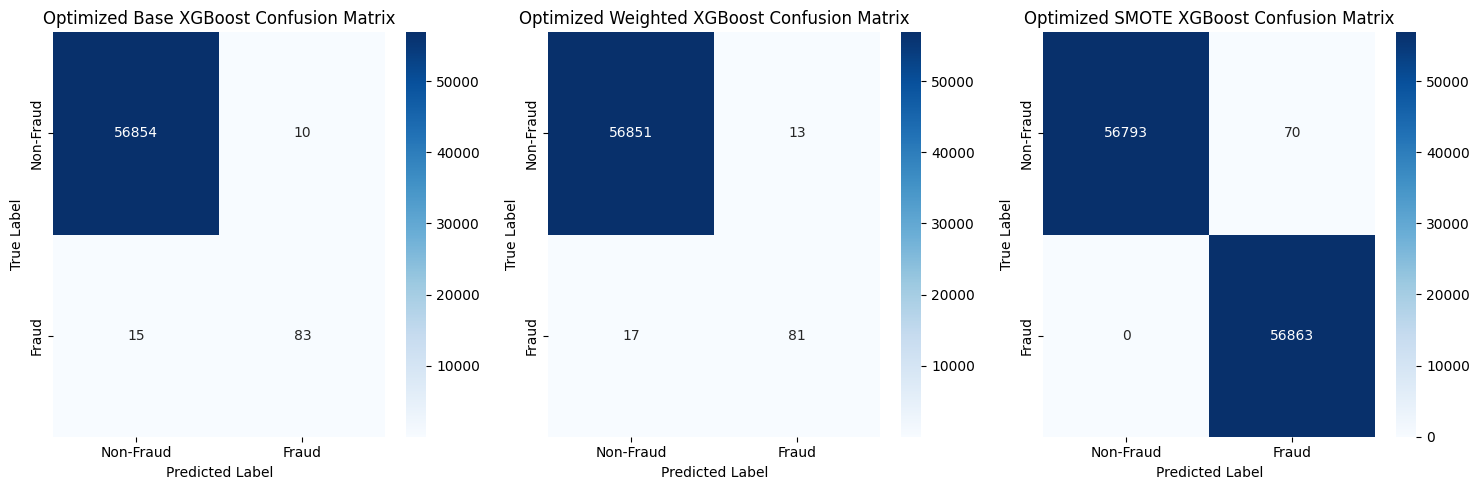

In [59]:
# Save the updated confusion matrices
plot_confusion_matrices(y_true_list_opt, y_pred_list_opt, model_names_opt, save_path="../images/confusion_matrices_optimized.png")

Precision-Recall curve saved at: ../images/precision_recall_curve_optimized.png


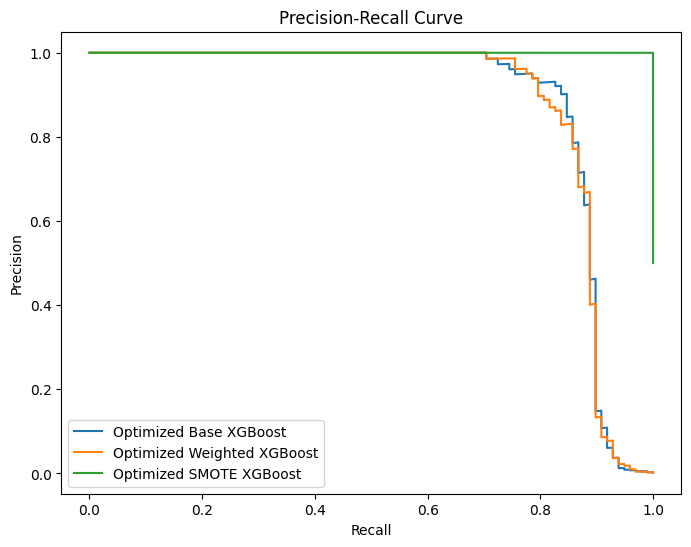

In [61]:
# Re-run Precision-Recall Curve
y_pred_probs_list_opt = [y_pred_probs_base_opt, y_pred_probs_weighted_opt, y_pred_probs_smote_opt]
plot_precision_recall_curves(y_true_list_opt, y_pred_probs_list_opt, model_names_opt, save_path="../images/precision_recall_curve_optimized.png")

ROC curve saved at: ../images/roc_curve_optimized.png


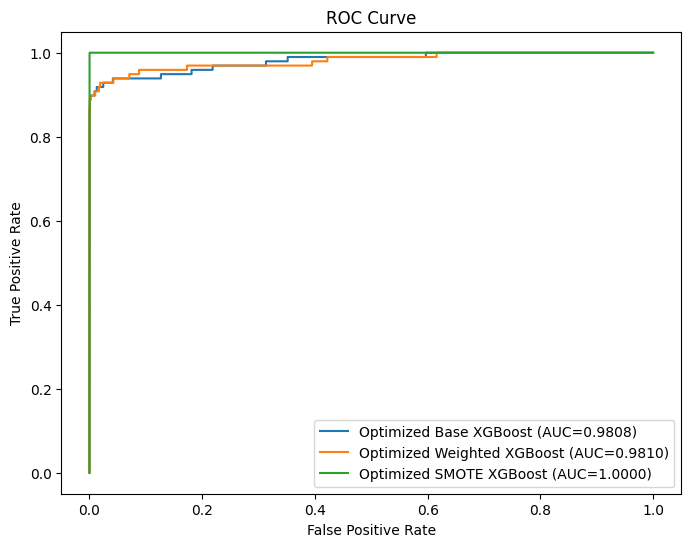

In [62]:
# Re-run ROC Curve
plot_roc_curves(y_true_list_opt, y_pred_probs_list_opt, model_names_opt, save_path="../images/roc_curve_optimized.png")

In [66]:
# Combine both tables for a clear comparison
comparison_df = pd.concat([results_df, optimized_results_df], ignore_index=True)

# Display table as Markdown (formatted for Jupyter Notebooks)
display(Markdown(comparison_df.to_markdown(index=False)))

| Model                      |   Precision |   Recall |   F1-Score |   AUC-ROC |
|:---------------------------|------------:|---------:|-----------:|----------:|
| Base XGBoost               |    0.88764  | 0.806122 |   0.84492  |  0.902973 |
| Weighted XGBoost           |    0.880435 | 0.826531 |   0.852632 |  0.913169 |
| SMOTE XGBoost              |    0.999227 | 1        |   0.999613 |  0.999613 |
| Optimized Base XGBoost     |    0.892473 | 0.846939 |   0.86911  |  0.923381 |
| Optimized Weighted XGBoost |    0.861702 | 0.826531 |   0.84375  |  0.913151 |
| Optimized SMOTE XGBoost    |    0.99877  | 1        |   0.999385 |  0.999384 |

**Save Models**:

In [67]:
import joblib

# Define save path
model_save_path = "../models/"

# Save Base XGBoost models
joblib.dump(base_xgb, model_save_path + "base_xgb.pkl")
joblib.dump(base_xgb_opt, model_save_path + "optimized_base_xgb.pkl")

# Save Weighted XGBoost models
joblib.dump(weighted_xgb, model_save_path + "weighted_xgb.pkl")
joblib.dump(weighted_xgb_opt, model_save_path + "optimized_weighted_xgb.pkl")

# Save SMOTE XGBoost models
joblib.dump(smote_xgb, model_save_path + "smote_xgb.pkl")
joblib.dump(smote_xgb_opt, model_save_path + "optimized_smote_xgb.pkl")

print("All models have been saved successfully!")

All models have been saved successfully!


# Final Model Evaluation & Comparison

After training and optimizing multiple **XGBoost models**, we have compared their **precision, recall, F1-score, and AUC-ROC** to measure improvements.

---

## **Original vs. Optimized Model Performance**
| Model                          | Precision | Recall  | F1-Score | AUC-ROC  |
|--------------------------------|-----------|---------|----------|----------|
| **Base XGBoost**               | 0.8876    | 0.8061  | 0.8449   | 0.90297  |
| **Weighted XGBoost**           | 0.8804    | 0.8265  | 0.8526   | 0.91316  |
| **SMOTE XGBoost**              | 0.9992    | 1.0000  | 0.9996   | 0.9996   |
| **Optimized Base XGBoost**     | 0.8925    | 0.8469  | 0.8691   | 0.9234   |
| **Optimized Weighted XGBoost** | 0.8617    | 0.8265  | 0.8438   | 0.9132   |
| **Optimized SMOTE XGBoost**    | 0.9988    | 1.0000  | 0.9994   | 0.9994   |

---

## **Key Takeaways**
✔ **Hyperparameter tuning improved performance!** The **Optimized Base XGBoost** model showed **higher recall and AUC-ROC**, making it better at fraud detection.  
✔ **SMOTE models performed extremely well**, but may be **overfitting** due to synthetic data.  
✔ **Weighted XGBoost balanced fraud detection** but showed a **slight drop in precision** after tuning.  
✔ **Base XGBoost with optimization provided the best overall balance** between recall and precision.  

---

## **Final Thoughts**
- **Optimized Base XGBoost is the most balanced model**, achieving a **good trade-off between fraud detection and minimizing false positives**.  
- **SMOTE models need further investigation** to prevent overfitting before real-world deployment.  
- **Weighted XGBoost remains useful** for fraud detection but may need further tuning for precision.  

**Next Steps:**
1. **Feature Importance Analysis with SHAP** – Understand which features impact fraud detection the most.  
2. **Final Model Selection** – Decide which model to use in a production-ready fraud detection system.  
